In [7]:
pip install mplsoccer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# libraries
import pandas as pd
import numpy as np
from mplsoccer import Pitch,VerticalPitch, PyPizza
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# load data
events = pd.read_csv('Data/events_SerieA_2021-22.csv', index_col='eventId')
print(events.shape)
events.head()

(1019431, 92)


,matchId,matchDayIndex,homeSquadId,homeSquadName,awaySquadId,awaySquadName,eventNumber,sequenceIndex,periodId,gameTime,...,CRITICAL_BALL_LOSS_NUMBER,BALL_LOSS_REMOVED_TEAMMATES_DEFENDERS,ASSISTS,SHOT_XG,SUCCESSFUL_PASSES,UNSUCCESSFUL_PASSES,OFFENSIVE_TOUCHES,DEFENSIVE_TOUCHES,POSTSHOT_XG,NEUTRAL_PASS
eventId,,,,,,,,,,,,,,,,,,,,,
4378882115,67944,34,237,Juventus FC,2519,Venezia FC,0,0,1,00:00.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4378882116,67944,34,237,Juventus FC,2519,Venezia FC,1,0,1,00:01.7333,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4378882117,67944,34,237,Juventus FC,2519,Venezia FC,2,0,1,00:01.7334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4378882118,67944,34,237,Juventus FC,2519,Venezia FC,3,0,1,00:03.0182,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4378882119,67944,34,237,Juventus FC,2519,Venezia FC,4,0,1,00:04.7390,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


# Feature Engineering

All the variables that are used throughout this project and that do not come directly from the IMPECT data, are created here:

In [10]:
# opponent name (to compute allowed actions)
events['opponentName'] = np.where(events['squadId'] == events['homeSquadId'], events['awaySquadName'], events['homeSquadName'])
# action types dummies
events['SHOTS'] = np.where(events['actionType']=='SHOT',1,0)
events['PASSES'] = np.where(events['actionType']=='PASS',1,0)
events['DRIBBLES'] = np.where(events['actionType']=='DRIBBLES',1,0)
events['SUCCESSFUL_PASSES'] = np.where((events['actionType']=='PASS') & (events['result']=='SUCCESS'),1,0)
events['successfulPassFinalThird'] = np.where((
    events['actionType']=='PASS') &
     ((events['endPitchPosition']=='FINAL_THIRD')|(events['endPitchPosition']=='OPPONENT_BOX')) &
      (events['result']=='SUCCESS'),1,0)
events['successfulPassInsideBox'] = np.where((
    events['actionType']=='PASS') & (events['endPitchPosition']=='OPPONENT_BOX') & (events['result']=='SUCCESS'),1,0)
# Bypassed opponents per action type
events['BYPASSED_OPPONENTS_PASS'] = np.where(events['actionType']=='PASS',events['BYPASSED_OPPONENTS'],0)
events['BYPASSED_OPPONENTS_DRIBBLE'] = np.where(events['actionType']=='DRIBBLE',events['BYPASSED_OPPONENTS'],0)
# Invert coordinates for allowed actions (team box should be in the left)
events['endAdjCoordinatesX_opp'] = -1*events['endAdjCoordinatesX']
events['endAdjCoordinatesY_opp'] = -1*events['endAdjCoordinatesY']
# Game Time
events['minute'] = events['gameTime'].str[:2].astype(int)
# Fixture name
events['fixture'] = (events['matchDayIndex']+1).astype(str) + ": " + events['homeSquadName'] + ' - ' + events['awaySquadName']

A dataframe containing the final standings in the league is created here. This allow to later in the project to easily use a subset of teams as baseline to compare Cagliari's data.

In [11]:
# create df with final standings
df_pos = {
    'team': [
        'AC Milan',
        'Inter',
        'SSC Napoli',
        'Juventus FC',
        'SS Lazio',
        'AS Roma',
        'ACF Fiorentina',
        'Atalanta',
        'Hellas Verona',
        'Torino FC',
        'US Sassuolo',
        'Udinese Calcio',
        'Bologna FC',
        'Empoli FC',
        'UC Sampdoria',
        'Spezia Calcio',
        'US Salernitana 1919',
        'Cagliari Calcio',
        'Genoa CFC',
        'Venezia FC'
    ],
    'position_final': [
        1,  # Milan
        2,  # Inter
        3,  # Napoli
        4,  # Juventus
        5,  # Lazio
        6,  # Roma
        7,  # Fiorentina
        8,  # Atalanta
        9,  # Verona
        10, # Torino
        11, # Sassuolo
        12, # Udinese
        13, # Bologna
        14, # Empoli
        15, # Sampdoria
        16, # Spezia
        17, # Salernitana
        18, # Cagliari
        19, # Genoa
        20  # Venezia
    ]
}

df_pos = pd.DataFrame(df_pos)


# Season-level analysis

## Pizza plot of teams offensive and deffensive performance

In [12]:
# SELECTED TEAM:
team = "Cagliari Calcio"

In [13]:
# DF WITH TEAM OFFENSIVE AND DEFFENSIVE SEASON METRICS
# ---------------------------------------------------

# selected metrics to analyze
kpis = [
    "POSTSHOT_XG",
    "SHOTS",
    "BYPASSED_OPPONENTS_DRIBBLE",
    "BYPASSED_OPPONENTS_PASS",
    "BYPASSED_DEFENDERS",
    "successfulPassFinalThird",
    'OFFENSIVE_TOUCHES',
    "GOALS"
]

# number of matches per team in data
n_matches = len(events['matchDayIndex'].unique())

# aggregate offensive and deffensive metrics
d = {k: 'sum' for k in kpis}
df_off = events.groupby('squadName', as_index=False).agg(d)
df_def = events.groupby('opponentName', as_index=False).agg(d)

# merge offensive and deffensive into one df
df_def = df_def.rename(columns={'opponentName': 'squadName'})
team_season_kpi = df_off.merge(df_def, on='squadName',suffixes=('_OWN','_ALLOWED'))

# Per 90' values
numeric_cols = team_season_kpi.select_dtypes(include=['int64', 'float64']).columns
team_season_kpi[numeric_cols] = team_season_kpi[numeric_cols]/n_matches

In [14]:
# Add columns with team's percentile for each metric
# ---------------------------------------------------

# define the KPI lists
attack_kpis = [
    k + "_OWN" for k in kpis
]
def_kpis = [
    k + "_ALLOWED" for k in kpis
]

# function to calculate percentiles
def percentile_rank(series):
    """Returns percentile rank for each value in a pandas Series."""
    return series.rank(pct=True) * 100

# create columns with team's percentile for each metric
for k in attack_kpis:
    team_season_kpi[k + "_PERC"] = percentile_rank(team_season_kpi[k])
for k in def_kpis:
    # for defence, invert percentiles (lower allowed is better)
    team_season_kpi[k + "_PERC"] = 100 - percentile_rank(team_season_kpi[k])

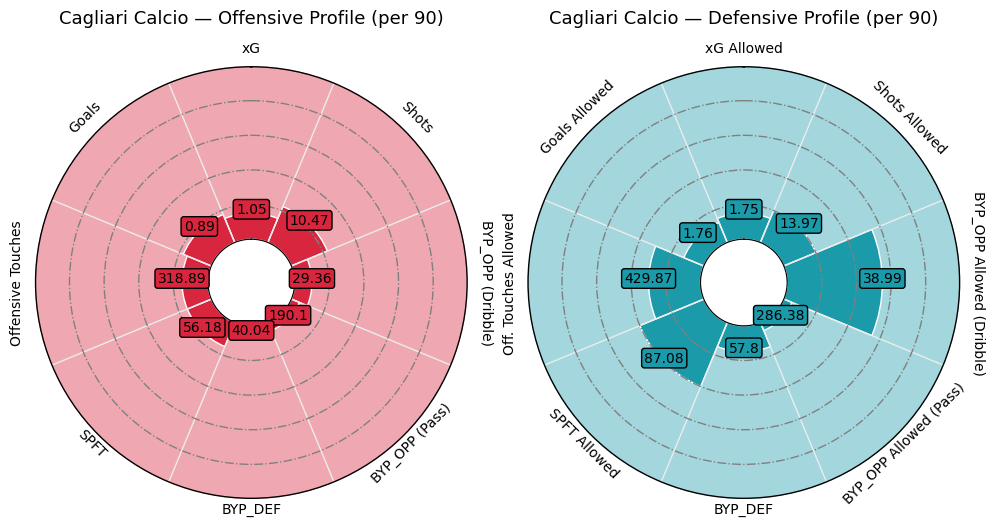

In [15]:
# PIZA PLOTS WITH TEAM METRICS
# ---------------------------------------------------


# extract selected team data
row = team_season_kpi[team_season_kpi['squadName'] == team].iloc[0]
attack_percentiles = [row[k + "_PERC"] for k in attack_kpis]
attack_actual = [row[k] for k in attack_kpis]
def_percentiles = [row[k + "_PERC"] for k in def_kpis]
def_actual = [row[k] for k in def_kpis]

# titles for KPIs (more readable)
attack_labels = [
     "xG", "Shots","BYP_OPP (Dribble)",
    "BYP_OPP (Pass)",  "BYP_DEF",
    "SPFT", 'Offensive Touches',"Goals"
]
def_labels = [
     "xG Allowed", "Shots Allowed","BYP_OPP Allowed (Dribble)",
    "BYP_OPP Allowed (Pass)",  "BYP_DEF",
    "SPFT Allowed", 'Off. Touches Allowed',"Goals Allowed"
]

# Common pizza plot settings
pizza_params = {
    'straight_line_color': "#ECECEC",
    'straight_line_lw': 1,
    'last_circle_lw': 2,
    'other_circle_lw': 1,
    'other_circle_ls': "-.",
    'inner_circle_size': 25
}

# Shared slice kwargs
attack_slice_kwargs = dict(facecolor="#D7263D", edgecolor="#FFFFFF", linewidth=1)
def_slice_kwargs = dict(facecolor="#1B9AAA", edgecolor="#FFFFFF", linewidth=1)

# Shared value kwargs
value_kwargs = dict(
    color="#000000", fontsize=10,
    bbox=dict(boxstyle="round,pad=0.2", facecolor="#D7263D", edgecolor="#000000")
)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

# Attack Pizza
baker_att = PyPizza(params=attack_labels, **pizza_params)
baker_att.make_pizza(
    attack_percentiles,
    ax=ax1,
    color_blank_space="same",
    blank_alpha=0.4,
    alt_text_values=np.round(attack_actual, 2),
    kwargs_slices=attack_slice_kwargs,
    kwargs_params=dict(color="#000000", fontsize=10),
    kwargs_values=value_kwargs
)
ax1.set_title(f"{team} — Offensive Profile (per 90)", fontsize=13, y=1.08)

# Defense Pizza (override color in value_kwargs for defense)
value_kwargs_def = value_kwargs.copy()
value_kwargs_def['bbox']['facecolor'] = "#1B9AAA"

baker_def = PyPizza(params=def_labels, **pizza_params)
baker_def.make_pizza(
    def_percentiles,
    ax=ax2,
    color_blank_space="same",
    blank_alpha=0.4,
    alt_text_values=np.round(def_actual, 2),
    kwargs_slices=def_slice_kwargs,
    kwargs_params=dict(color="#000000", fontsize=10),
    kwargs_values=value_kwargs_def
)
ax2.set_title(f"{team} — Defensive Profile (per 90)", fontsize=13, y=1.08)

plt.tight_layout()
plt.savefig('pizza_plot_team_season.png')
plt.show()


Comments:

*   As expected for a team that ended up being relegated, Caglairi struggles at both ends of the pitch.
*   Offense seems to be the biggest issue, almost all the considered metrics put Cagliari at the bottom 4 of the league. The team is actually the worst in terms of bypassing defenders and bypassing opponents by passes.
* Given this results, the rest of the project focuses on examining in detail the reasons behind this poor progressive game.



## Diagnosing Cagliari's passing system: Bypassed Opponents and Successful passes

This section seeks to examine Cagliari's ability to bypass opponents via passes.

In [16]:
# DF WITH SEASON LEVEL DATA BY TEAM
# -------------------------------------------------------------

team_season_kpi = events.groupby('squadName').agg({
    'BYPASSED_OPPONENTS_PASS':'sum',
    'PASSES':'sum',
    'SUCCESSFUL_PASSES':'sum',
    'POSTSHOT_XG':'sum'
}).reset_index()
# per 90' values
team_season_kpi['POSTSHOT_XG'] = team_season_kpi['POSTSHOT_XG']/38
team_season_kpi['PASSES'] = team_season_kpi['PASSES']/38
team_season_kpi['SUCCESSFUL_PASSES'] = team_season_kpi['SUCCESSFUL_PASSES']/38
team_season_kpi['BYPASSED_OPPONENTS_PASS'] =  team_season_kpi['BYPASSED_OPPONENTS_PASS']/38

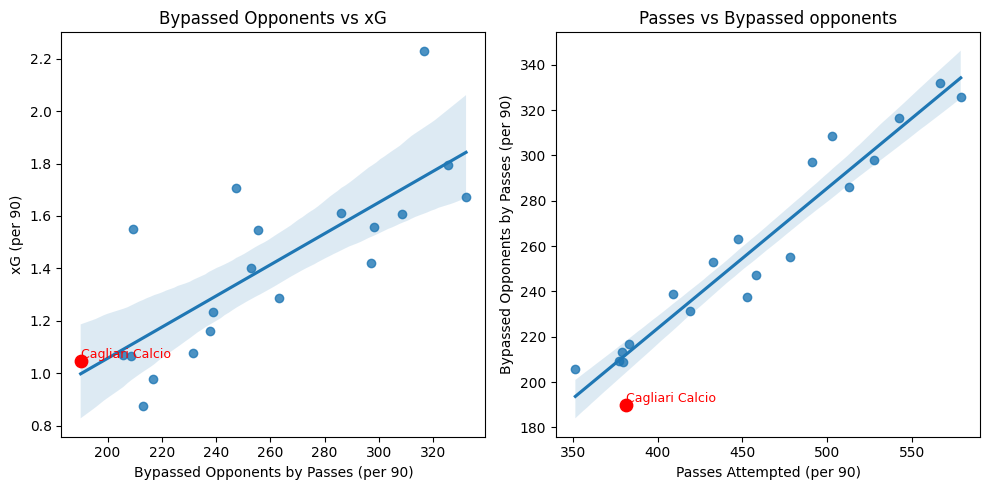

In [17]:
# Plot trend between Bypassed opponents (per pass) vs Successful Passes
# -------------------------------------------------------------

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

##################
# xG vs Bypassed
x ='BYPASSED_OPPONENTS_PASS'
y = 'POSTSHOT_XG'
sns.regplot(x=x,y=y,data=team_season_kpi,ax=axes[0])
# highlight team
row_team = team_season_kpi[team_season_kpi['squadName'] == team].iloc[0]
axes[0].scatter(row_team[x], row_team[y], color='red', s=80, zorder=5)
axes[0].text(row_team[x], row_team[y], team, ha='left', va='bottom', fontsize=9, color='red')
axes[0].set_title("Bypassed Opponents vs xG")
axes[0].set_xlabel("Bypassed Opponents by Passes (per 90)")
axes[0].set_ylabel("xG (per 90)")

###################
# Bypassed vs sp
x ='PASSES'
y = 'BYPASSED_OPPONENTS_PASS'
g= sns.regplot(x=x,y=y,data=team_season_kpi,ax=axes[1])
# Add labels to each point
axes[1].scatter(row_team[x], row_team[y], color='red', s=80, zorder=5)
axes[1].text(row_team[x], row_team[y], team, ha='left', va='bottom', fontsize=9, color='red')
axes[1].set_title("Passes vs Bypassed opponents")
axes[1].set_xlabel("Passes Attempted (per 90)")
axes[1].set_ylabel("Bypassed Opponents by Passes (per 90)")

plt.tight_layout()
plt.savefig('lm_plot_pass_bypassed.png')
plt.show()

Comments:

*   To bypass opponents via passes is key to produce more xG.
*   Cagliari has the lowest level of bypassed opponents with passes, and the third lowest in total successful passes.
* Cagliari is bypassing even less opponents than what their number of passes would suggest based on the league trend. Actually the team has the lowest ratio of bypassed opponents per pass as shown by the below table. Suggesting the team's struggles to progress with passes.



In [18]:
# compute average bypassed opponents per SPFT
df = events[(events['actionType']=='PASS')].groupby('squadName').agg({
    'PASSES':'sum',
    'BYPASSED_OPPONENTS':'sum'
    }).reset_index()
df['PASSES'] = df['PASSES']/38
df['BYPASSED_OPPONENTS'] =  df['BYPASSED_OPPONENTS']/38
df['avg_bypassed_opponents'] = df['BYPASSED_OPPONENTS']/df['PASSES']
df.sort_values('avg_bypassed_opponents').head()

,squadName,PASSES,BYPASSED_OPPONENTS,avg_bypassed_opponents
5,Cagliari Calcio,381.236842,190.095526,0.498628
14,Torino FC,452.552632,237.737895,0.525327
0,AC Milan,478.131579,255.376316,0.534113
2,AS Roma,457.894737,247.297632,0.540075
13,Spezia Calcio,379.263158,208.830526,0.550622


In [19]:
df[df['squadName']!=team]['avg_bypassed_opponents'].mean()

np.float64(0.568673800901616)

## Diagnosing Cagliari's passing system: Availability between the lines

An alternative way of examining ball progession for the team, instead of bypassed opponents, is to look at the number of times team-mates are found in between lines. This is useful, as the similar levels of bypassed opponents could be for example achieved by one long diagonal ball from a defender, or multiple sequences. Therefore, the number of times players have received the ball between lines is useful as complementary information.

In [20]:
# DF WITH AVAILABILITY BETWEEN LINES BY TEAM PER 90'
# ------------------------------------

df_btl = events[events['action']=="AVAILABILITY_BTL"]
df_btl = df_btl.groupby('squadName').agg({
    'action':'count'
}).reset_index()
df_btl['available_btl_90'] = df_btl['action']/38
print(f'Median: {df_btl['available_btl_90'].median()}')
print(f'Mean: {df_btl['available_btl_90'].mean()}')

Median: 73.6842105263158
Mean: 78.3263157894737


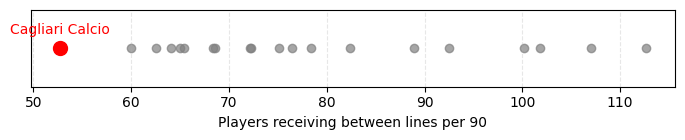

In [21]:
# PLOT
# ------------------------------------

plt.figure(figsize=(7, 1.5))

# Plot all points on a single horizontal line
plt.scatter(df_btl['available_btl_90'], [0]*len(df_btl), color='gray', alpha=0.7)

# Highlight Cagliari
team_val = df_btl[df_btl['squadName'] == team]['available_btl_90'].values[0]
plt.scatter(team_val, 0, color='red', s=100, label=team, zorder=3)
plt.text(team_val, 0.02, team, color='red', ha='center', fontsize=10)

# format
plt.yticks([])  # remove y-axis
plt.xlabel("Players receiving between lines per 90")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("line_plot_availability_btl.png")
plt.show()

Comments:

* Cagliari has the lowest level of teammates find between lines in the league, by some margin.

The next cells examine how the availability between lines distributes in the pitch, and compares it with the other 9 teams that end up in the bottom half in the league (to have a more realistic baseline of what the team could aspire for).

In [22]:
# availability between lines by pitch position
# -----------------------------------------------

# compute df with metric
df_btl = events[events['action']=="AVAILABILITY_BTL"].groupby(['squadName','startPitchPosition']).agg({
    'action':'count'
}).reset_index()
df_btl = df_btl.rename(columns={'action':'AVAILABILITY_BTL'})
df_btl['AVAILABILITY_BTL'] = (df_btl['AVAILABILITY_BTL']/38).round(1) #per 90

# Cagliari
df_team = df_btl[df_btl['squadName']==team]
df_team = df_team.drop(columns='squadName')
print(f'{team}')
print(df_team)
print('---------')

# Bottom half (exc. Cagliari)
name_teams = set(df_pos.sort_values('position_final')['team'][10:])
n_teams = len(name_teams)-1   # number of opponents
df_league = df_btl[df_btl['squadName'].isin(name_teams)] # filter teams
df_league = df_league.groupby('startPitchPosition').agg({
    'AVAILABILITY_BTL':'mean'
}) # average
df_league['AVAILABILITY_BTL'] = (df_league['AVAILABILITY_BTL']).round(1)
print('Bottom half (exc. Cagliari)')
print(df_league)


Cagliari Calcio
   startPitchPosition  AVAILABILITY_BTL
20        FINAL_THIRD              13.9
21        FIRST_THIRD               8.4
22       MIDDLE_THIRD              29.6
23            OWN_BOX               0.7
---------
Bottom half (exc. Cagliari)
                    AVAILABILITY_BTL
startPitchPosition                  
FINAL_THIRD                     18.9
FIRST_THIRD                     10.4
MIDDLE_THIRD                    39.3
OWN_BOX                          0.9


Comments:

* This comparison suggest that Cagliari's problems finding available players between lines is a biggest issue in the middle and final thirds.

## Diagnosing Cagliari's passing system: Type of passes attempted

In order to understand the reasons behind the teams lower capacity to progress on the pitch with passes, we are going to examine the type of passes the team is attempting.

Note: I am going to focus on two types of passes, low and chipped, as these are the two most frequent passes in a match that are more representative of team strategy. Headers are for most teams more frequent than chipped passes, but this actions can be the result of crosses, set pieces, clearances, aerial passes, etc. So it's more difficult to draw ideas from them.

In [23]:
# DF WITH PASS TYPE FREQUENCY AND ACCURACY
# ------------------------------------

df = events[events['actionType']=="PASS"].groupby(['squadName','action']).agg({
    'PASSES':'sum',
    'SUCCESSFUL_PASSES':'sum'
    }).reset_index()
df['PASS_FRACTION'] = df['PASSES']/df.groupby('squadName')['PASSES'].transform('sum') # pass type frequency (fraction)
df['PASS_ACCURACY'] = df['SUCCESSFUL_PASSES']/df['PASSES'] # pass type accuracy


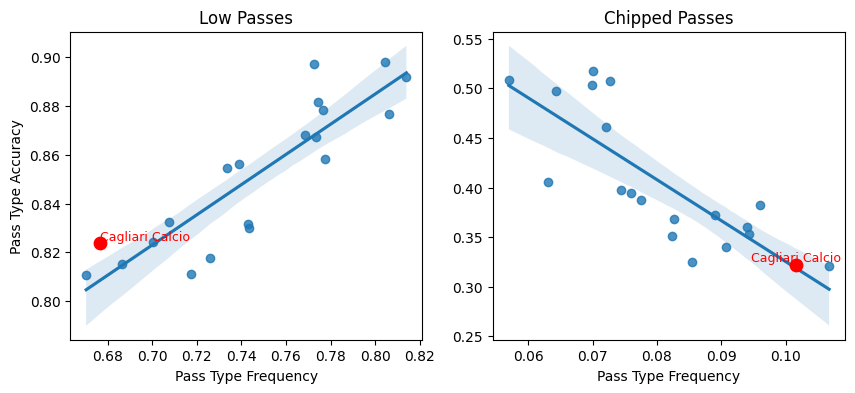

In [24]:
# Plot lm plot xG vs SPFT
# ---------------------

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
x ='PASS_FRACTION'
y = 'PASS_ACCURACY'

##################
# Low Passes
data = df[df['action']=="LOW_PASS"]
sns.regplot(x=x,y=y,data=data,ax=axes[0])
# highlight team
row_team = data[data['squadName'] == team].iloc[0]
axes[0].scatter(row_team[x], row_team[y], color='red', s=80, zorder=5)
axes[0].text(row_team[x], row_team[y], team, ha='left', va='bottom', fontsize=9, color='red')
# design
axes[0].set_title("Low Passes")
axes[0].set_xlabel("Pass Type Frequency")
axes[0].set_ylabel("Pass Type Accuracy")

###################
# Chipped Passes
data = df[df['action']=="CHIPPED_PASS"]
g= sns.regplot(x=x,y=y,data=data,ax=axes[1])
# highlight team
row_team = data[data['squadName'] == team].iloc[0]
axes[1].scatter(row_team[x], row_team[y], color='red', s=80, zorder=5)
axes[1].text(row_team[x], row_team[y], team,ha='center', va='bottom', fontsize=9, color='red')
# design
axes[1].set_title("Chipped Passes")
axes[1].set_xlabel("Pass Type Frequency")
axes[1].set_ylabel("")

#plt.tight_layout()
plt.savefig('lm_plot_pass_type.png')
plt.show()

Comments:
* Cagliari is the second team relying less on low passes, and more on chipped passes.
* Positive relation between frequency and accuracy for low passes, and negative relation for chipped passes is seen. This suggests than teams like Cagliari, might be avoiding safe low passes to try riskier chipped passes, which, at least for Cagliari, has not translated into progess on the field more effectively.

One could argue that players might be relying on chipped passes when they see themselves under pressure, so maybe Cagliari's high level of chipped passes attempted is due to opponent pressing and not team strategy. However, the next cells provide evidence against this. The team is actually receiving on average the third lowest pressure when attempting this passes.

In [25]:
# DF WITH AVERAGE PRESSURE WHEN CHIPPED PASS ARE ATTEMPTED, BY TEAM
# ------------------------------------

df_press = events[events['action']=='CHIPPED_PASS'].groupby(['squadName']).agg({
    'pressure':'mean'
    }).reset_index()


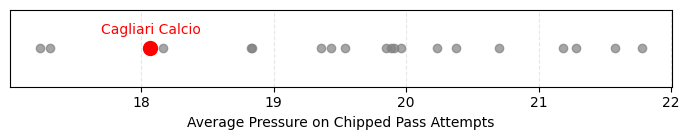

In [26]:
# PLOT
# ------------------------------------

plt.figure(figsize=(7, 1.5))

# Plot all points on a single horizontal line
plt.scatter(df_press['pressure'], [0]*len(df_press), color='gray', alpha=0.7)

# Highlight Cagliari
team_val = df_press[df_press['squadName'] == team]['pressure'].values[0]
plt.scatter(team_val, 0, color='red', s=100, label=team, zorder=3)
plt.text(team_val, 0.02, team, color='red', ha='center', fontsize=10)

# format
plt.yticks([])  # remove y-axis
plt.xlabel("Average Pressure on Chipped Pass Attempts")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.savefig("line_plot_pressure_chipped_passes.png")
plt.show()

# Player Analysis

This section seeks to examine what are the most relevant Cagliari players to effectively progress on the pitch, both as passers and receivers.

Instead of considering the whole season, I choose to focus on a subset of games. I will simulate a context where only the last 5 league games remain to be played, and I will only consider the previous 5 games in order to have representative performance for the players.

In [27]:
# DF with passer metrics
# -------------------------

# filter selected games
n_games = 5
df = events[
    (events['squadName']==team) &
    (events['actionType']=="PASS") &
    (events['matchDayIndex']<33) & # games before matchday 34
    (events['matchDayIndex']>=(33-n_games))
    ]

# aggregate metrics by player
df_passers = df.groupby(['playerId','playerName']).agg({
    'PASSES':'sum',
    'SUCCESSFUL_PASSES':'sum',
    'BYPASSED_OPPONENTS':'sum'
}).reset_index()

# create features
df_passers['Accuracy'] = df_passers['SUCCESSFUL_PASSES']/df_passers['PASSES']
df_passers['BYP_OPP_PP'] = df_passers['BYPASSED_OPPONENTS']/df_passers['PASSES']

# edit df
df_passers = df_passers.drop(columns=['SUCCESSFUL_PASSES'])
df_passers = df_passers[['playerName','PASSES','Accuracy','BYPASSED_OPPONENTS','BYP_OPP_PP']]
#df_passers.sort_values('PASSES',ascending=False).head(8)

In [28]:
# DF with receiver metrics
# -------------------------

# filter selected games
n_games = 5
df = events[
    (events['squadName']==team) &
    (events['actionType']=="PASS") &
    (events['matchDayIndex']<33) & # last 5 games before matchday 34
    (events['matchDayIndex']>=(33-n_games))
    ]

# aggregate metrics by player
df_receivers = df.groupby(['passReceiverPlayerId','passReceiverPlayerName']).agg({
    'PASSES':'sum',
    'BYPASSED_OPPONENTS':'sum'
}).reset_index()

# create features
df_receivers['BYP_OPP_PP'] = df_receivers['BYPASSED_OPPONENTS']/df_receivers['PASSES']

# edit df
df_receivers = df_receivers.rename(columns={'passReceiverPlayerName':'playerName'})
df_receivers = df_receivers[['playerName','PASSES','BYPASSED_OPPONENTS','BYP_OPP_PP']]
#df_receivers.sort_values('BYPASSED_OPPONENTS',ascending=False).head(5)

In [29]:
# DF WITH MAIN PLAYER POSITION
# -----------------------

# filter selected games
n_games = 5
df = events[
    (events['squadName']==team) &
    (events['matchDayIndex']<33) & # last 5 games before matchday 34
    (events['matchDayIndex']>=(33-n_games))
    ]

# find main position for each player (position whit more passes)
df_player_pos = df.groupby(['playerName','playerPosition']).agg({
    'PASSES':'sum'
}).reset_index()
max_indices = df_player_pos.groupby('playerName')['PASSES'].idxmax()
df_player_pos = df_player_pos.loc[max_indices]
df_player_pos = df_player_pos.drop(columns='PASSES')

In [30]:
# MERGE PASSER, RECEIVER AND MAIN POSITION
# ----------------------

df_players = df_passers.merge(df_receivers,on='playerName',suffixes=('_P','_R'),how='outer')
df_players = df_players[df_players['PASSES_P']>20] # filter minimum passes
# add main player position
df_players = df_players.merge(df_player_pos,on='playerName')
df_players.sort_values('BYPASSED_OPPONENTS_P', ascending=False)

,playerName,PASSES_P,Accuracy,BYPASSED_OPPONENTS_P,BYP_OPP_PP_P,PASSES_R,BYPASSED_OPPONENTS_R,BYP_OPP_PP_R,playerPosition
10,Giorgio Altare,193.0,0.663212,112.79,0.584404,101,11.6,0.114851,CENTRAL_DEFENDER
7,Edoardo Goldaniga,138.0,0.659420,105.86,0.767101,87,20.7,0.237931,CENTRAL_DEFENDER
15,Matteo Lovato,152.0,0.769737,78.87,0.518882,75,0.3,0.004000,CENTRAL_DEFENDER
2,Alessio Cragno,75.0,0.506667,78.30,1.044000,51,1.0,0.019608,GOALKEEPER
0,Alberto Grassi,163.0,0.699387,68.33,0.419202,82,27.7,0.337805,DEFENSE_MIDFIELD
16,Raoul Bellanova,150.0,0.560000,60.00,0.400000,121,42.3,0.349587,RIGHT_WINGBACK_DEFENDER
5,Dalbert,109.0,0.614679,58.06,0.532661,70,62.1,0.887143,LEFT_WINGBACK_DEFENDER
17,Răzvan Marin,113.0,0.734513,44.75,0.396018,80,73.6,0.920000,CENTRAL_MIDFIELD
8,Gabriele Zappa,55.0,0.618182,44.70,0.812727,42,8.7,0.207143,RIGHT_WINGBACK_DEFENDER
3,Andrea Carboni,71.0,0.676056,43.41,0.611408,46,3.9,0.084783,CENTRAL_DEFENDER


Comments:
* Central defenders are key in bypassing opponents through passes, while centre forwards are key as receivers.
* This might suggest that progression often relies on direct passes into the forward line rather than through midfield combinations.


# Game-level Analysis

In [90]:
# select games (3 previous to gameweek 34)
games = [30,32]
n_games = len(games)

## Passing Network

This section seeks to examine the team’s passing system in more detail, by plotting its passing network for the three more recent games before the last 5 matches.

Note: Cagliari’s passing network will consider only the first halves of each match, to reduce the impact of substitutions and to better capture the team’s baseline structure, as later phases of matches are often heavily influenced by the scoreline.

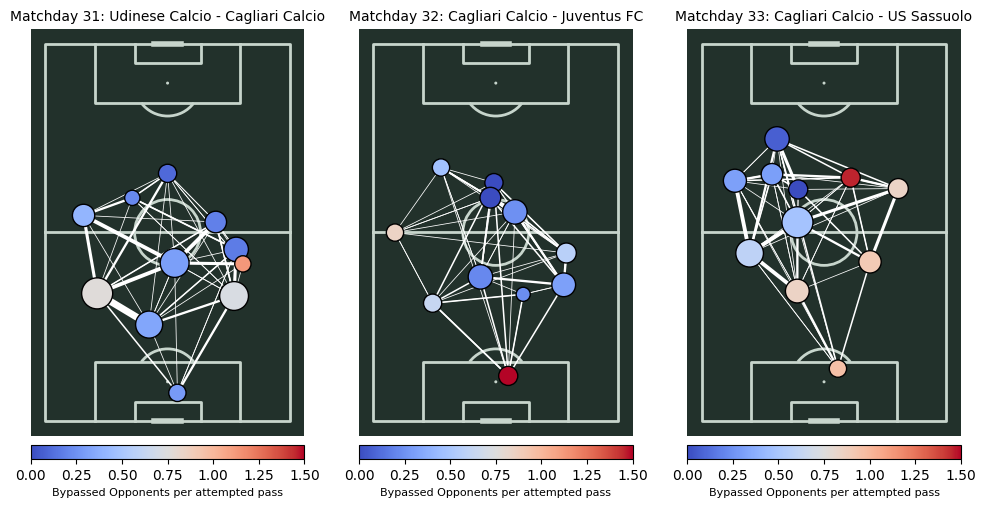

In [91]:
# PLOT PASSING NETWORK SELECTED GAMES
# --------------------------------------


# -----------------------------------
# DF with Average Player Position
# ------------------------------------
df_players = events[
    (events['squadName']==team) &
    (events['actionType']=="PASS") &
    (events['matchDayIndex'].isin(games)) & # matchday 34
    (events['minute']<45)
    ]
df_players = df_players.groupby(['playerId','playerName','fixture','matchDayIndex']).agg({
    'PASSES':'sum',
    'SUCCESSFUL_PASSES':'sum',
    'BYPASSED_OPPONENTS':'sum',
    'startAdjCoordinatesX':'mean',
    'startAdjCoordinatesY':'mean'
}).reset_index()
df_players['accuracy'] = df_players['SUCCESSFUL_PASSES']/df_players['PASSES']
df_players['BYPASSED_OPPONENTS_PP'] = df_players['BYPASSED_OPPONENTS']/df_players['PASSES']


# -----------------------------------
# DF with Passes Lines
# ------------------------------------
df_passes = events[
    (events['squadName']==team) &
    (events['actionType']=="PASS") &
    (events['matchDayIndex'].isin(games)) & # matchday 34
    (events['minute']<45)
    ]
df_passes = df_passes.groupby(['playerId','playerName','passReceiverPlayerId','passReceiverPlayerName','fixture','matchDayIndex']).agg({
    'PASSES':'sum',
    'SUCCESSFUL_PASSES':'sum',
    'BYPASSED_OPPONENTS':'sum'
}).reset_index()
# Add avg passer location
df_passes = df_passes.merge(df_players[['playerId','startAdjCoordinatesX','startAdjCoordinatesY','fixture','matchDayIndex']],
                            left_on=['playerId','fixture','matchDayIndex'],
                            right_on=['playerId','fixture','matchDayIndex'])
df_passes = df_passes.rename(columns={'startAdjCoordinatesX':'passer_x','startAdjCoordinatesY':'passer_y'})
# Add avg receiver location
df_passes = df_passes.merge(df_players[['playerId','startAdjCoordinatesX','startAdjCoordinatesY','fixture','matchDayIndex']],
                            left_on=['passReceiverPlayerId','fixture','matchDayIndex'],
                            right_on=['playerId','fixture','matchDayIndex'])
df_passes = df_passes.rename(columns={'startAdjCoordinatesX':'receiver_x','startAdjCoordinatesY':'receiver_y'})



# -----------------------------------
# Plot
# ------------------------------------
from matplotlib.colors import to_rgba

# Format visual
MAX_MARKER_SIZE = 500
df_players['marker_size'] = (df_players['PASSES']/ df_players['PASSES'].max() * MAX_MARKER_SIZE)
MAX_LINE_WIDTH = 5
df_passes['width'] = (df_passes['PASSES'] / df_passes['PASSES'].max() * MAX_LINE_WIDTH)

# Create pitch visual
pitch = VerticalPitch(pitch_type='impect', pitch_color='#22312b', line_color='#c7d5cc')
fig, axes = plt.subplots(nrows=1, ncols=n_games, figsize=(12, 6))

for i in range(n_games):
    # Filter game
    df_players_i = df_players[df_players['matchDayIndex']==games[i]]
    df_passes_i = df_passes[df_passes['matchDayIndex']==games[i]]

    # Draw the pitch on this subplot
    pitch.draw(ax=axes[i])

    # Calculate transparency for this game's passes
    MIN_TRANSPARENCY = 0.5
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(df_passes_i), 1))
    c_transparency = df_passes_i['PASSES'] / df_passes_i['PASSES'].max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    # Plotting passes between players (use filtered data)
    lines = pitch.lines(
        df_passes_i['passer_x'], df_passes_i['passer_y'],
        df_passes_i['receiver_x'], df_passes_i['receiver_y'],
        lw=df_passes_i['width'], ax=axes[i], color=color, alpha=1, zorder=1
    )

    # Plotting player avg positions (use filtered data)
    nodes = pitch.scatter(
        df_players_i['startAdjCoordinatesX'], df_players_i['startAdjCoordinatesY'],
        ax=axes[i],
        s=df_players_i['marker_size'],
        c=df_players_i['BYPASSED_OPPONENTS_PP'],
        cmap='coolwarm',
        edgecolors='black',
        vmin=0,
        vmax=1.5,
        linewidth=1,
        zorder=2
    )

    # Colorbar for bypassed opponents per pass
    cbar = plt.colorbar(nodes, ax=axes[i], fraction=0.03, pad=0.02, location='bottom')
    cbar.set_label("Bypassed Opponents per attempted pass", fontsize=8)
    axes[i].set_title(f'Matchday {df_players_i['fixture'].iloc[0]}', fontsize=10)

#fig.suptitle(f'{team}: Passing Network', fontsize=14, y=0.98)
#plt.tight_layout()
plt.savefig('passing_networks.png')
plt.show()

Comments:

* In the match won, against US Sassuolo, we can see a higher team positioning, higher levels of byspassed opponents per pass, a more compact structure (specially in the left side of the attack), and with less reliance on a small number of players.

In [81]:
# Calculate share of passes belonging to top 3 passers per game
grouped = df_passes.groupby(['matchDayIndex', 'playerName'])['PASSES'].sum().reset_index(name='PASSES')
grouped['matchTotalPasses'] = grouped.groupby('matchDayIndex')['PASSES'].transform('sum') # total passes in game
# share of top 3 with more passes
top3_per_match = (
    grouped
    .sort_values(['matchDayIndex', 'PASSES'], ascending=[True, False])
    .groupby('matchDayIndex')
    .head(3)
)
top3_per_match['share'] = top3_per_match['PASSES'] / top3_per_match['matchTotalPasses']
result = top3_per_match.groupby('matchDayIndex')['share'].sum().reset_index(name='top3_pass_share')

result.sort_values('matchDayIndex')

,matchDayIndex,top3_pass_share
0,30,0.491071
1,31,0.430233
2,32,0.429825


## Plot Successful passes into the final third

Caglairi's better performance on the last game can also be observed when plotting the successful passes in the final third. As shown by the below plot, against Sassuolo the team achieved a considerably higher number of successful passes in the final third, specially from low passes in the left wing.

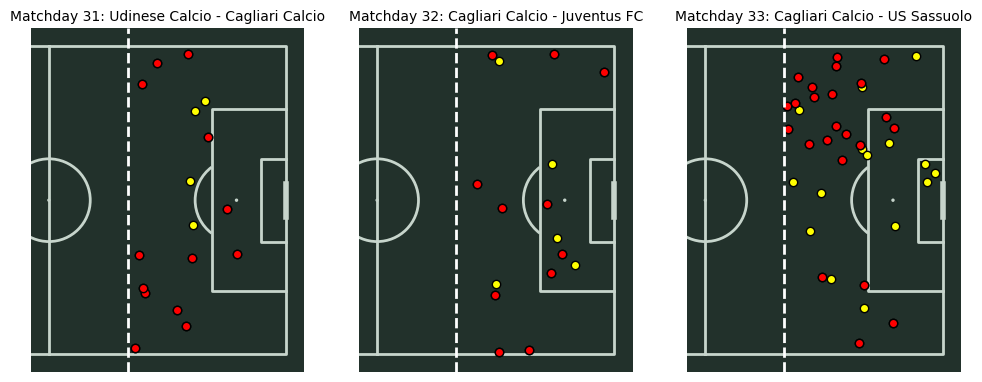

In [33]:
# PLOT SUCCESSFUL PASSES FINAL THIRD SELECTED GAMES
# --------------------------------

# df with successful passes in final third
df_spft = events[
    (events['squadName']==team) &
    (events['successfulPassFinalThird']==1) &
    (events['matchDayIndex'].isin(games)) & # matchday 34
    (events['minute']<45)
    ]

# -----------------------------------
# Plot
# ------------------------------------

# Create pitch visual
pitch = Pitch(pitch_type='impect', pitch_color='#22312b', line_color='#c7d5cc',half=True)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

for i in range(n_games):
    # Filter game
    df_spft_i = df_spft[df_spft['matchDayIndex']==games[i]]

    # Draw the pitch on this subplot
    pitch.draw(ax=axes[i])

    # 1. Plotting SPFT
    nodes = pitch.scatter(
        df_spft_i['endAdjCoordinatesX'],
        df_spft_i['endAdjCoordinatesY'],
        ax=axes[i],
        color='yellow',
        edgecolors='black',
        linewidth=1,
        zorder=2
    )
    # 2. Highlight LOW PASSES
    df_low_i = df_spft_i[df_spft_i['action'] == 'LOW_PASS']
    pitch.scatter(
        df_low_i['endAdjCoordinatesX'],
        df_low_i['endAdjCoordinatesY'],
        ax=axes[i],
        color='red',
        edgecolors='black',
        linewidth=1,
        zorder=2
    )

    axes[i].axvline(x=17.5, color='white', linestyle='--', linewidth=2)
    axes[i].set_title(f'Matchday {df_spft_i['fixture'].iloc[0]}', fontsize=10)

#fig.suptitle(f'{team}: Passing Network', fontsize=14, y=0.98)
#plt.tight_layout()
plt.savefig('spft_fixtures.png')
plt.show()